Modelo Prophet: Consumo Individual

In [48]:
import pandas as pd
import numpy as np
import mlflow
import mlflow.pyfunc
import dagshub
import matplotlib.pyplot as plt
from prophet import Prophet
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
import pickle
import subprocess

In [25]:
import os
print(os.getcwd())

c:\Users\anaig\OneDrive - U-tad\Curso5-Q2\Proyectos4\proyecto\GitHub-SGBA1\Proyectos-SGBA1\src\modelos\predictivo_hogar\notebooks


In [79]:
# Ruta del archivo
file_path = "../../../../data/processed/predictivo_hogar/consumo_salamanca_cleaned.csv"

# Cargar los datos
df = pd.read_csv(file_path)

In [80]:
# Asegurar que las columnas están correctamente nombradas
df.rename(columns={'datetime': 'ds', 'Consumo_kWh': 'y'}, inplace=True)

# Convertir la fecha a formato datetime y eliminar zona horaria si existe
df['ds'] = pd.to_datetime(df['ds']).dt.tz_localize(None)

# Ordenar por fecha (por si acaso no está ordenado)
df = df.sort_values(by='ds')

# Manejo de datos faltantes: rellenamos con interpolación lineal
df['y'] = df['y'].interpolate(method='linear')

In [81]:
# Añadir variable para identificar fines de semana (1 si es sábado o domingo, 0 en otros días)
df['weekend'] = df['ds'].dt.weekday.isin([5, 6]).astype(int)

# Añadir variable de día de la semana (0=Lunes, ..., 6=Domingo)
df['day_of_week'] = df['ds'].dt.weekday

# Añadir variable de mes del año (1-12)
df['month'] = df['ds'].dt.month

# Crear dataframe con los días festivos
df_festivos = df[df['es_festivo'] == 1][['ds']]  


In [82]:
# Definir el punto de corte para la validación (últimos 7 días)
split_date = df['ds'].max() - pd.Timedelta(days=7)

# Dividir en entrenamiento y validación
train = df[df['ds'] <= split_date]
test = df[df['ds'] > split_date]

In [83]:
# Crear y ajustar el modelo Prophet con hiperparámetros optimizados
model = Prophet(
    seasonality_mode='multiplicative',  # Se cambia a multiplicativo para mejorar en datos con variaciones relativas
    changepoint_prior_scale=0.03,  # Reducimos para evitar sobreajuste en cambios abruptos
    holidays_prior_scale=10  # Aumentamos el peso de los festivos
)

# Añadir la estacionalidad mensual con Fourier optimizado
model.add_seasonality(name='monthly', period=30.5, fourier_order=10)

# Añadir la estacionalidad anual con Fourier más detallado
model.add_seasonality(name='yearly', period=365.25, fourier_order=15)

# Añadir los días festivos
holidays = pd.DataFrame({
    'ds': df_festivos['ds'],
    'holiday': 'festivo'
})
model.add_seasonality(name='festivos', period=365, fourier_order=10)
model.add_country_holidays(country_name='ES')

# Incluir nuevas variables como regresores
model.add_regressor('weekend')
model.add_regressor('day_of_week')
model.add_regressor('month')

# Ajustar el modelo
model.fit(train)

22:44:03 - cmdstanpy - INFO - Chain [1] start processing
22:45:24 - cmdstanpy - INFO - Chain [1] done processing


In [84]:
# Hacer predicciones
future = test[['ds', 'weekend', 'day_of_week', 'month']]  # Asegurar que incluimos las variables agregadas
forecast = model.predict(future)

# Evaluar el modelo
y_true = test['y'].values
y_pred = forecast['yhat'].values

mae = mean_absolute_error(y_true, y_pred)
rmse = np.sqrt(mean_squared_error(y_true, y_pred))

In [85]:
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")

Mean Absolute Error (MAE): 0.1306
Root Mean Squared Error (RMSE): 0.1679


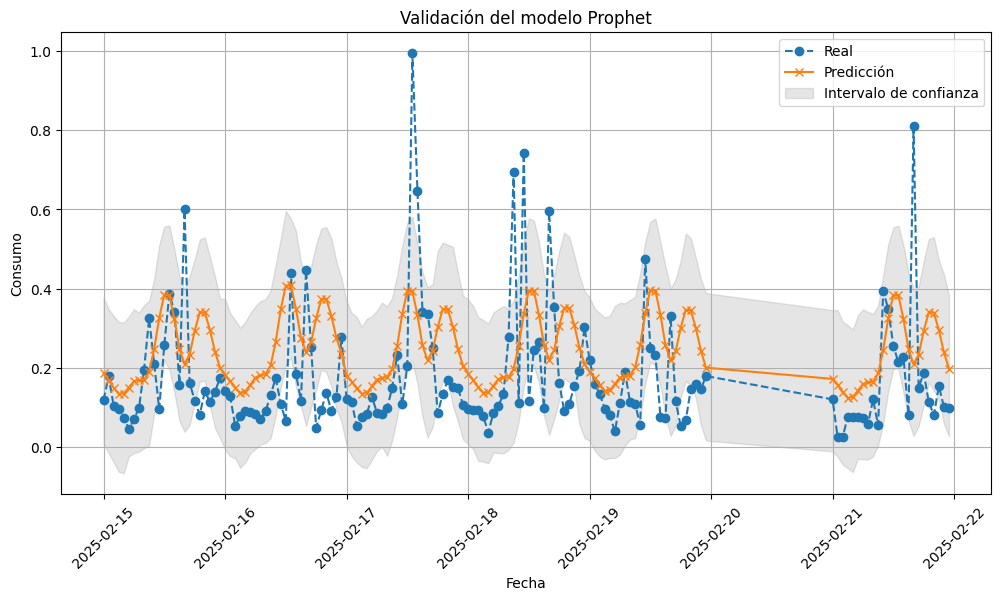

In [86]:
# Graficar resultados
plt.figure(figsize=(12, 6))
plt.plot(test['ds'], y_true, label="Real", marker='o', linestyle="dashed")
plt.plot(test['ds'], y_pred, label="Predicción", marker='x')
plt.fill_between(test['ds'], forecast['yhat_lower'], forecast['yhat_upper'], color='gray', alpha=0.2, label="Intervalo de confianza")
plt.legend()
plt.title("Validación del modelo Prophet")
plt.xlabel("Fecha")
plt.ylabel("Consumo")
plt.xticks(rotation=45)
plt.grid()
plt.show()

Ahora con MLFlow

In [87]:

# Configurar DAGsHub con MLflow
dagshub.init(repo_owner='auditoria.SGBA1', repo_name='SGBA1-smartgrids', mlflow=True)
mlflow.set_tracking_uri("https://dagshub.com/auditoria.SGBA1/SGBA1-smartgrids.mlflow")
mlflow.set_experiment("Predicción Precio Luz con Prophet")


Initialized MLflow to track repo "auditoria.SGBA1/SGBA1-smartgrids"

Repository auditoria.SGBA1/SGBA1-smartgrids initialized!

<Experiment: artifact_location='mlflow-artifacts:/fd4a2e5b3f2c4b358051b572353ec8fa', creation_time=1740567102864, experiment_id='5', last_update_time=1740567102864, lifecycle_stage='active', name='Predicción Precio Luz con Prophet', tags={}>

In [88]:
# Clase personalizada para Prophet en MLflow
class ProphetWrapper(mlflow.pyfunc.PythonModel):
    def __init__(self, model):
        self.model = model

    def predict(self, context, model_input):
        model_input = pd.DataFrame(model_input)
        model_input.columns = ['ds']
        forecast = self.model.predict(model_input)
        return forecast[['ds', 'yhat']]

c:\Users\anaig\AppData\Local\Programs\Python\Python310\lib\site-packages\mlflow\pyfunc\utils\data_validation.py:134: UserWarning: Add type hints to the `predict` method to enable data validation and automatic signature inference during model logging. Check https://mlflow.org/docs/latest/model/python_model.html#type-hint-usage-in-pythonmodel for more details.
  color_warning(


22:53:17 - cmdstanpy - INFO - Chain [1] start processing
22:55:39 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error (MAE): 0.1306
Root Mean Squared Error (RMSE): 0.1679


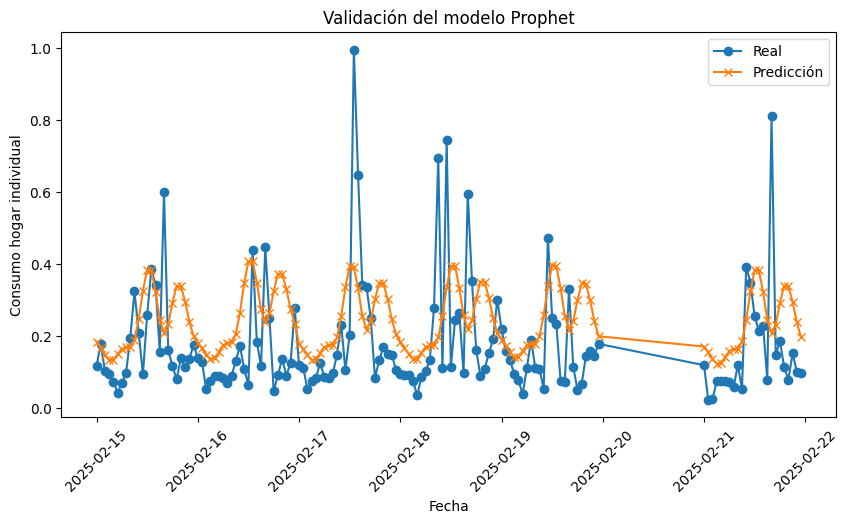

2025/03/04 22:55:47 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
Successfully registered model 'Prophet-Consumo-Hogar'.
2025/03/04 22:55:51 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: Prophet-Consumo-Hogar, version 1
Created version '1' of model 'Prophet-Consumo-Hogar'.


¡Modelo registrado en DAGsHub y MLflow correctamente con Run ID: afc187a51e314db3a56a9aa2d6912753!
🏃 View run silent-loon-274 at: https://dagshub.com/auditoria.SGBA1/SGBA1-smartgrids.mlflow/#/experiments/5/runs/afc187a51e314db3a56a9aa2d6912753
🧪 View experiment at: https://dagshub.com/auditoria.SGBA1/SGBA1-smartgrids.mlflow/#/experiments/5


In [91]:
# Iniciar experimento en MLflow
with mlflow.start_run() as run:
    run_id = run.info.run_id  # Guardamos el Run ID

    # Registrar parámetros
    mlflow.log_param("modelo", "Prophet")
    mlflow.log_param("periodo_validacion_dias", 7)

    # Crear y ajustar el modelo Prophet con regresores adicionales
    model = Prophet(
        seasonality_mode='multiplicative',
        changepoint_prior_scale=0.03,
        holidays_prior_scale=10
    )

    # Añadir la estacionalidad mensual con Fourier optimizado
    model.add_seasonality(name='monthly', period=30.5, fourier_order=10)

    # Añadir la estacionalidad anual con Fourier más detallado
    model.add_seasonality(name='yearly', period=365.25, fourier_order=15)

    # Añadir los días festivos
    holidays = pd.DataFrame({
        'ds': df_festivos['ds'],
        'holiday': 'festivo'
    })
    model.add_seasonality(name='festivos', period=365, fourier_order=10)
    model.add_country_holidays(country_name='ES')

    # Incluir nuevas variables como regresores
    model.add_regressor('weekend')
    model.add_regressor('day_of_week')
    model.add_regressor('month')

    # Ajustar el modelo
    model.fit(train)

    # Hacer predicciones
    future = test[['ds', 'weekend', 'day_of_week', 'month']]
    forecast = model.predict(future)

    # Evaluar el modelo
    y_true = test['y'].values
    y_pred = forecast['yhat'].values

    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))

    # Registrar métricas en MLflow
    mlflow.log_metric("MAE", mae)
    mlflow.log_metric("RMSE", rmse)

    print(f"Mean Absolute Error (MAE): {mae:.4f}")
    print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")

    # Graficar resultados
    plt.figure(figsize=(10, 5))
    plt.plot(test['ds'], y_true, label="Real", marker='o')
    plt.plot(test['ds'], y_pred, label="Predicción", marker='x')
    plt.legend()
    plt.title("Validación del modelo Prophet")
    plt.xlabel("Fecha")
    plt.ylabel("Consumo hogar individual")
    plt.xticks(rotation=45)

    # Guardar la imagen y subirla a MLflow
    validation_plot_path = "validacion_prediccion.png"
    plt.savefig(validation_plot_path)
    mlflow.log_artifact(validation_plot_path)
    plt.show()

    # Registrar el modelo en MLflow usando la clase personalizada
    model_name = "Prophet-Consumo-Hogar"
    model_uri = f"runs:/{run_id}/prophet_model"

    mlflow.pyfunc.log_model(artifact_path="prophet_model", python_model=ProphetWrapper(model))

    # Registrar el modelo en MLflow Model Registry
    mlflow.register_model(model_uri=model_uri, name=model_name)

    print(f"¡Modelo registrado en DAGsHub y MLflow correctamente con Run ID: {run_id}!")